In [ ]:
!pip install opencc
!pip install ArticutAPI
!pip install nltk

In [1]:
import pandas as pd
import numpy as np
from ArticutAPI import Articut
from pprint import pprint
import pickle
import re
import jieba 
import jieba.analyse
import jieba.posseg as pseg
from collections import Counter
import math
import os
from opencc import OpenCC
import nltk
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties as font

In [ ]:
# setting for wordcloud

from wordcloud import WordCloud
font_path = 'your font path'
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']

wc = WordCloud(background_color='white',
                margin=2, 
                font_path=font_path,
                max_words=200, 
                width=1280, height=720) 

In [ ]:
# downloda nltk chinese stopWords and translate to traditional Chinese

cc = OpenCC('s2t')
nltk.download('stopwords')
stopWords = stopwords.words('chinese')
stopWords = [cc.convert(word) for word in stopWords]

In [11]:
# setting for articut api

config = { 
    "username":"", # use free 2,000 word per day without api key
    "articut_key":""}
    
articut = Articut(config['username'],config['articut_key'])

In [138]:
def wordExtractor(inputLIST, unify=True, StopWords=None):

    '''
    配合 Articut() 的 .getNounStemLIST() 和 .getVerbStemLIST() …等功能，拋棄位置資訊，只抽出詞彙。
    我另外又加上是否去除停用詞的選項，default 是 None，則和原本一樣，或著送入list 作為停用詞
    '''
    resultLIST = []

    for item in inputLIST:
        if item == []:
            pass
        else:
            for word in item:
                resultLIST.append(word[-1])
    if StopWords == None:
        pass
    else:
        resultLIST = [word for word in resultLIST if word not in StopWords]
        
    if unify == True:
        output = sorted(list(set(resultLIST)))
    else:
        output =  sorted(resultLIST)

    return output

def counterCosinSimilarity(RESULT1, RESULT2, terms=None, stopWords=None):
    '''
    微更改原本的demo function， 輸入變成吃 articut.parse 的 Result，wordExtractor 與Counter 我寫在function 裏面了
    '''

    counter01 = Counter(wordExtractor(inputLIST=RESULT1,
                                    unify=False, 
                                    StopWords=stopWords))
    counter02 = Counter(wordExtractor(inputLIST=RESULT2,
                                    unify=False, 
                                    StopWords=stopWords))
    
    if terms == None:
        terms = set(counter01).union(counter02)
    dotprod = sum(counter01.get(k, 0) * counter02.get(k, 0) for k in terms)
    magA = math.sqrt(sum(counter01.get(k, 0) ** 2 for k in terms))
    magB = math.sqrt(sum(counter02.get(k, 0) ** 2 for k in terms))

    return dotprod / (magA * magB)

def jiebaPosExtractor(text, unify=True, StopWords=None):

    '''
    紀錄Jieba 斷詞語Pos tagging 的結果
    '''

    words = pseg.cut(text)

    result = []
    verb_ = []
    num_ = []
    adj_ = []
    per_ = []
    for word, flag in words:
        if StopWords != None:
            if word in StopWords:
                continue

        result.append((flag, word))
        if flag in ['v', 'vd','vn']:
            verb_.append(word)
        elif flag in ['n', 'nr', 'nz']:
            num_.append(word)
        elif flag in ['nr', 'PER']:
            per_.append(word)
        elif flag in ['a', 'ad', 'an', 'd']:
            adj_.append(word)

    
    if unify == True:
        verb_ = sorted(list(set(verb_)))
        num_ = sorted(list(set(num_)))
        adj_ = sorted(list(set(adj_)))
        per_ = sorted(list(set(per_)))

    return result, verb_, num_, adj_, per_, 


In [12]:
rawData = pd.read_excel('data/公司自我介紹.xlsx')
rawData['簡介'] = rawData['簡介'].str.replace(" ", "").replace("\n", "")

#### **Jieba vs ArticutAPI**

In [74]:
rawData.head()

,公司,簡介
0,玉山金控,1992年，創辦人黃永仁董事長結合志同道合的專業團隊，在台灣創立以「玉山」為名的銀行，懷著「...
1,國泰金控,國泰金融控股股份有限公司於民國九十年十二月三十一日正式成立，登記額定資本額新台幣一千二百億元...
2,元大金控,元大金控長期深耕台灣，以涵蓋全省之綿密據點及萬名專業金融服務人員，提供客戶全方位金融服務。元...
3,富邦金控,以「成為亞洲一流的金融機構」為發展願景的富邦金控，旗下主要子公司包括富邦人壽、台北富邦銀行、...
4,Appier,Appier是軟體即服務(SaaS)公司，使用人工智慧(AI)技術推動業務決策。Appier...


定義好function 之後，就可以來斷詞，這邊我都有使用停用詞，分別看``Articu API`` 與``Jieba`` 在名詞與動詞的分詞結果

In [272]:
company = 'Appier'
text = rawData.loc[rawData.公司 == company]['簡介'].values[0]
result = articut.parse(text)

VerbResultLIST = articut.getVerbStemLIST(result)
NounResultLIST = articut.getNounStemLIST(result)

articutVerb = wordExtractor(inputLIST=VerbResultLIST, 
                            unify=True, 
                            StopWords=stopWords)
articutNoun = wordExtractor(inputLIST=NounResultLIST, 
                            unify=True, 
                            StopWords=stopWords)
result, verb_, num_, adj_, per_,  = jiebaPosExtractor(text=text, 
                                                    unify=True, 
                                                    StopWords=stopWords)
pd.DataFrame.from_dict({'articutVerb': articutVerb,
                'jiebaVerb': verb_,
                '': ['']* max(len(articutVerb), len(verb_), len(articutNoun), len(num_)),
                'articutNoun': articutNoun,
                'jiebaNoun':num_},
                orient='index').transpose().head(10)

,articutVerb,jiebaVerb,,articutNoun,jiebaNoun
0,利用,制訂,,AI,公司
1,制訂,協助,,Appier,利用
2,協助,成立,,SaaS,客戶
3,成立,推動,,人工,成果
4,推動,推廣,,以上客戶,房間
5,推廣,擴展,,公司,技術
6,擴展,服務,,地區,數位
7,服務,行銷,,客戶,業務
8,營業,設計,,房間,決策
9,行銷,轉型,,技術,營業


可以發現在動詞的部分差異並不大，但名詞Articut 則可以吃到一些更代表的字詞，例如SaaS，因為該詞是英文，在Jieba 中會被分到 ``eng``，無法判斷詞性。

- 轉換成文字雲看看

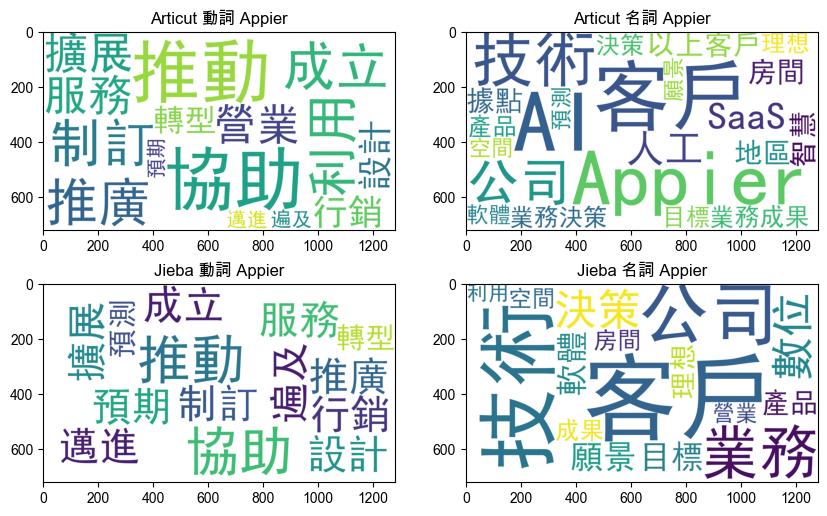

In [273]:
articutVerb = wordExtractor(inputLIST=VerbResultLIST, 
                            unify=False, 
                            StopWords=stopWords)
articutNoun = wordExtractor(inputLIST=NounResultLIST, 
                            unify=False, 
                            StopWords=stopWords)
result, verb_, num_, adj_, per_,  = jiebaPosExtractor(text=text, 
                                                    unify=False, 
                                                    StopWords=stopWords)

plt.figure(figsize=(10, 6))
for idx, output in enumerate(zip([articutVerb, articutNoun, verb_, num_], ['Articut 動詞', 'Articut 名詞', 'Jieba 動詞', 'Jieba 名詞'])):
    plt.subplot(2, 2, idx+1)
    wc.generate_from_frequencies(Counter(output[0]))
    plt.imshow(wc)
    plt.title(f'{output[1]} {company}')

In [270]:
company = 'Awoo'
text = rawData.loc[rawData.公司 == company]['簡介'].values[0]
result = articut.parse(text)

VerbResultLIST = articut.getVerbStemLIST(result)
NounResultLIST = articut.getNounStemLIST(result)

articutVerb = wordExtractor(inputLIST=VerbResultLIST, 
                            unify=True, 
                            StopWords=stopWords)
articutNoun = wordExtractor(inputLIST=NounResultLIST, 
                            unify=True, 
                            StopWords=stopWords)
result, verb_, num_, adj_, per_,  = jiebaPosExtractor(text=text, 
                                                    unify=True, 
                                                    StopWords=stopWords)
pd.DataFrame.from_dict({'articutVerb': articutVerb,
                'jiebaVerb': verb_,
                '': ['']* max(len(articutVerb), len(verb_), len(articutNoun), len(num_)),
                'articutNoun': articutNoun,
                'jiebaNoun':num_},
                orient='index').transpose().head(10)

,articutVerb,jiebaVerb,,articutNoun,jiebaNoun
0,了解,了解,,A,中心
1,個人化,優化,,AI,人化
2,優化,再行,,AILab,企業家
3,加值,創以,,MarTech,全
4,募資,加值,,SaaS,功能
5,協助,協助,,awooIntelligence,化
6,意圖,成立,,中心,嘉義
7,成立,打造,,人工,團隊
8,打造,投資,,企業家,專職
9,投資,接軌,,功能,平台


在Awoo 這邊可以看到，像這樣的新創或是Ai 公司一定會寫到英文如: AI、MarTech，``Articut API`` 顯現了其優勢，而``Jieba`` 在中文中會發生像：化、全，這樣的斷詞錯誤。

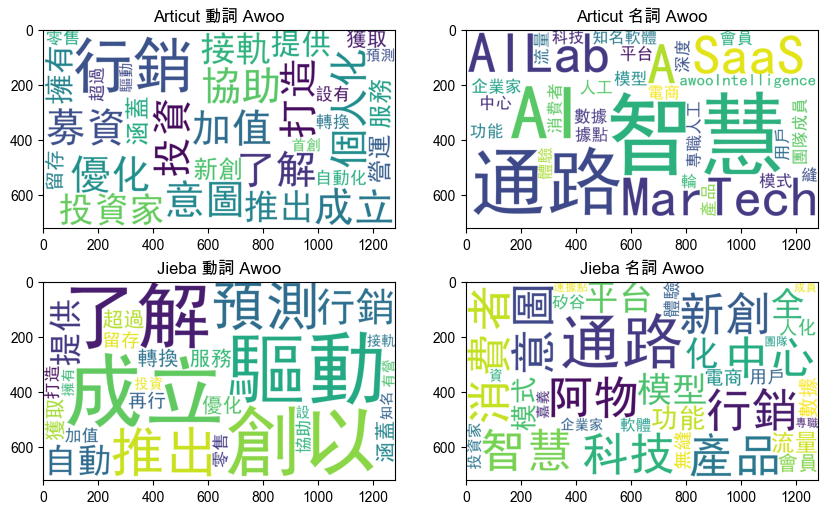

In [271]:
articutVerb = wordExtractor(inputLIST=VerbResultLIST, 
                            unify=False, 
                            StopWords=stopWords)
articutNoun = wordExtractor(inputLIST=NounResultLIST, 
                            unify=False, 
                            StopWords=stopWords)
result, verb_, num_, adj_, per_,  = jiebaPosExtractor(text=text, 
                                                    unify=False, 
                                                    StopWords=stopWords)

plt.figure(figsize=(10, 6))
for idx, output in enumerate(zip([articutVerb, articutNoun, verb_, num_], ['Articut 動詞', 'Articut 名詞', 'Jieba 動詞', 'Jieba 名詞'])):
    plt.subplot(2, 2, idx+1)
    wc.generate_from_frequencies(Counter(output[0]))
    plt.imshow(wc)
    plt.title(f'{output[1]} {company}')

In [268]:
company = '國泰金控'
text = rawData.loc[rawData.公司 == company]['簡介'].values[0]
result = articut.parse(text)

VerbResultLIST = articut.getVerbStemLIST(result)
NounResultLIST = articut.getNounStemLIST(result)

articutVerb = wordExtractor(inputLIST=VerbResultLIST, 
                            unify=True, 
                            StopWords=stopWords)
articutNoun = wordExtractor(inputLIST=NounResultLIST, 
                            unify=True, 
                            StopWords=stopWords)
result, verb_, num_, adj_, per_,  = jiebaPosExtractor(text=text, 
                                                    unify=True, 
                                                    StopWords=stopWords)
pd.DataFrame.from_dict({'articutVerb': articutVerb,
                'jiebaVerb': verb_,
                '': ['']* max(len(articutVerb), len(verb_), len(articutNoun), len(num_)),
                'articutNoun': articutNoun,
                'jiebaNoun':num_},
                orient='index').transpose().head(10)

,articutVerb,jiebaVerb,,articutNoun,jiebaNoun
0,享受,享受,,cross-selling,人員
1,信賴,付,,one-stopshopping,作業
2,值得,伴,,人員,保險
3,回饋,使,,作業,信賴
4,工作,值得,,保險,優質
5,成為,回饋,,公司,全省
6,成立,工作,,分支機構,公司
7,打造,強化,,力,分支
8,投資,成為,,功能,功能
9,持續,成立,,區域平台,化


除了英文問題以外，發現``ArticuAPI`` 和``Jieba`` 發生類似斷詞錯誤，如：力，但``ArticuAPI`` 可以斷出如「區域平台」，這樣通常不會在自定義詞典出現，卻又是我們中文常見的詞語，而``Jieba`` 則只能斷出平台。

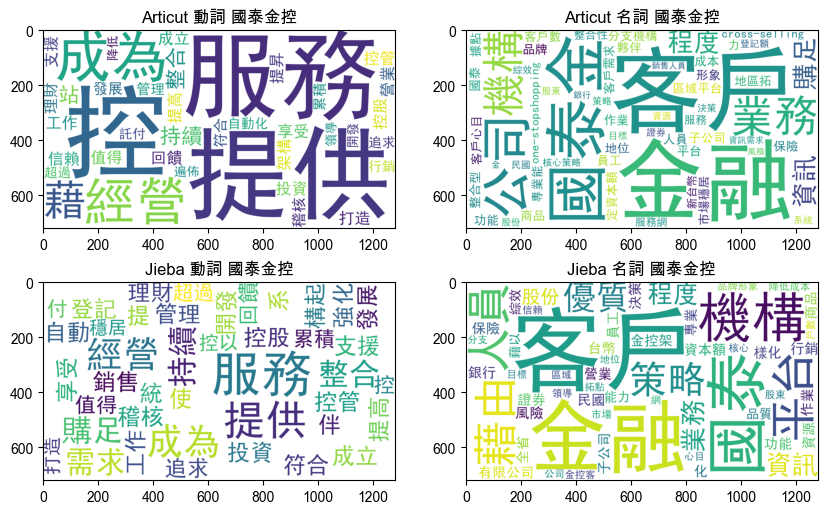

In [269]:
articutVerb = wordExtractor(inputLIST=VerbResultLIST, 
                            unify=False, 
                            StopWords=stopWords)
articutNoun = wordExtractor(inputLIST=NounResultLIST, 
                            unify=False, 
                            StopWords=stopWords)
result, verb_, num_, adj_, per_,  = jiebaPosExtractor(text=text, 
                                                    unify=False, 
                                                    StopWords=stopWords)
plt.figure(figsize=(10, 6))
for idx, output in enumerate(zip([articutVerb, articutNoun, verb_, num_], ['Articut 動詞', 'Articut 名詞', 'Jieba 動詞', 'Jieba 名詞'])):
    plt.subplot(2, 2, idx+1)
    wc.generate_from_frequencies(Counter(output[0]))
    plt.imshow(wc)
    plt.title(f'{output[1]} {company}')

#### **利用動名詞做文本相似度**

In [175]:
company1 = '國泰金控'
company2 = '玉山金控'

text1 = rawData.loc[rawData.公司 == company1]['簡介'].values[0]
text2 = rawData.loc[rawData.公司 == company2]['簡介'].values[0]
result1 = articut.parse(text1)
result2 = articut.parse(text2)
resultLIST1 = articut.getVerbStemLIST(result1)
resultLIST2 = articut.getVerbStemLIST(result2)

similarity = counterCosinSimilarity(resultLIST1, resultLIST2)
print(f'{company1} vs {company2} 動詞相似度 {similarity}')

resultLIST1 = articut.getNounStemLIST(result1)
resultLIST2 = articut.getNounStemLIST(result2)

similarity = counterCosinSimilarity(resultLIST1, resultLIST2)
print(f'{company1} vs {company2} 名詞相似度 {similarity}')

resultLIST1 = articut.analyse.extract_tags(result1)
resultLIST2 = articut.analyse.extract_tags(result2)
similarity = counterCosinSimilarity(resultLIST1, resultLIST2)
print(f'{company1} vs {company2} TFIDF相似度 {similarity}')

國泰金控 vs 玉山金控 動詞相似度 0.4822354489342862
國泰金控 vs 玉山金控 名詞相似度 0.22998675142327324
國泰金控 vs 玉山金控 TFIDF相似度 0.3424747597107866


In [176]:
# company1 = '國泰金控'
company2 = 'iKala'

# text1 = rawData.loc[rawData.公司 == company1]['簡介'].values[0]
text2 = rawData.loc[rawData.公司 == company2]['簡介'].values[0]
# result1 = articut.parse(text1)
result2 = articut.parse(text2)
resultLIST1 = articut.getVerbStemLIST(result1)
resultLIST2 = articut.getVerbStemLIST(result2)

similarity = counterCosinSimilarity(resultLIST1, resultLIST2)
print(f'{company1} vs {company2} 動詞相似度 {similarity}')

resultLIST1 = articut.getNounStemLIST(result1)
resultLIST2 = articut.getNounStemLIST(result2)

similarity = counterCosinSimilarity(resultLIST1, resultLIST2)
print(f'{company1} vs {company2} 名詞相似度 {similarity}')


國泰金控 vs iKala 動詞相似度 0.36103584630253305
國泰金控 vs iKala 名詞相似度 0.22857142857142856


##### - **上面可以發現國泰和玉山相似度都比國泰與iKala 高，其中名詞與動詞比 TFIDF 顯著**

接者看看其他產業、公司的結果

In [173]:
company1 = 'iKala'
company2 = 'Appier'

text1 = rawData.loc[rawData.公司 == company1]['簡介'].values[0]
text2 = rawData.loc[rawData.公司 == company2]['簡介'].values[0]
result1 = articut.parse(text1)
result2 = articut.parse(text2)
resultLIST1 = articut.getVerbStemLIST(result1)
resultLIST2 = articut.getVerbStemLIST(result2)

similarity = counterCosinSimilarity(resultLIST1, resultLIST2)
print(f'{company1} vs {company2} 動詞相似度 {similarity}')

resultLIST1 = articut.getNounStemLIST(result1)
resultLIST2 = articut.getNounStemLIST(result2)

similarity = counterCosinSimilarity(resultLIST1, resultLIST2)
print(f'{company1} vs {company2} 名詞相似度 {similarity}')

resultLIST1 = articut.analyse.extract_tags(result1)
resultLIST2 = articut.analyse.extract_tags(result2)
similarity = counterCosinSimilarity(resultLIST1, resultLIST2)
print(f'{company1} vs {company2} TFIDF相似度 {similarity}')

iKala vs Appier 動詞相似度 0.2855936038564354
iKala vs Appier 名詞相似度 0.3151354388633341
iKala vs Appier TFIDF相似度 0.33375078288117255


In [144]:
company1 = '玉山金控'
company2 = '富邦金控'

text1 = rawData.loc[rawData.公司 == company1]['簡介'].values[0]
text2 = rawData.loc[rawData.公司 == company2]['簡介'].values[0]
result1 = articut.parse(text1)
result2 = articut.parse(text2)
resultLIST1 = articut.getVerbStemLIST(result1)
resultLIST2 = articut.getVerbStemLIST(result2)

similarity = counterCosinSimilarity(resultLIST1, resultLIST2)
print(f'{company1} vs {company2} 動詞相似度 {similarity}')

resultLIST1 = articut.getNounStemLIST(result1)
resultLIST2 = articut.getNounStemLIST(result2)

similarity = counterCosinSimilarity(resultLIST1, resultLIST2)
print(f'{company1} vs {company2} 名詞相似度 {similarity}')

玉山金控 vs 富邦金控 動詞相似度 0.304848934251503
玉山金控 vs 富邦金控 名詞相似度 0.18536245637099633


In [172]:
company1 = '玉山金控'
company2 = 'iKala'

text1 = rawData.loc[rawData.公司 == company1]['簡介'].values[0]
text2 = rawData.loc[rawData.公司 == company2]['簡介'].values[0]
result1 = articut.parse(text1)
result2 = articut.parse(text2)
resultLIST1 = articut.getVerbStemLIST(result1)
resultLIST2 = articut.getVerbStemLIST(result2)

similarity = counterCosinSimilarity(resultLIST1, resultLIST2)
print(f'{company1} vs {company2} 動詞相似度 {similarity}')

resultLIST1 = articut.getNounStemLIST(result1)
resultLIST2 = articut.getNounStemLIST(result2)

similarity = counterCosinSimilarity(resultLIST1, resultLIST2)
print(f'{company1} vs {company2} 名詞相似度 {similarity}')

resultLIST1 = articut.analyse.extract_tags(result1)
resultLIST2 = articut.analyse.extract_tags(result2)
similarity = counterCosinSimilarity(resultLIST1, resultLIST2)
print(f'{company1} vs {company2} TFIDF相似度 {similarity}')

玉山金控 vs iKala 動詞相似度 0.323974270985057
玉山金控 vs iKala 名詞相似度 0.19222773253288508
玉山金控 vs iKala TFIDF相似度 0.15929827321607745


In [171]:
company1 = '台積電'
company2 = 'iKala'

text1 = rawData.loc[rawData.公司 == company1]['簡介'].values[0]
text2 = rawData.loc[rawData.公司 == company2]['簡介'].values[0]
result1 = articut.parse(text1)
result2 = articut.parse(text2)
resultLIST1 = articut.getVerbStemLIST(result1)
resultLIST2 = articut.getVerbStemLIST(result2)

similarity = counterCosinSimilarity(resultLIST1, resultLIST2)
print(f'{company1} vs {company2} 動詞相似度 {similarity}')

resultLIST1 = articut.getNounStemLIST(result1)
resultLIST2 = articut.getNounStemLIST(result2)

similarity = counterCosinSimilarity(resultLIST1, resultLIST2)
print(f'{company1} vs {company2} 名詞相似度 {similarity}')

resultLIST1 = articut.analyse.extract_tags(result1)
resultLIST2 = articut.analyse.extract_tags(result2)
similarity = counterCosinSimilarity(resultLIST1, resultLIST2)
print(f'{company1} vs {company2} TFIDF相似度 {similarity}')

台積電 vs iKala 動詞相似度 0.21083297159711722
台積電 vs iKala 名詞相似度 0.2319998187502124
台積電 vs iKala TFIDF相似度 0.19968076595771792


In [170]:
company1 = '台積電'
company2 = '元大金控'

text1 = rawData.loc[rawData.公司 == company1]['簡介'].values[0]
text2 = rawData.loc[rawData.公司 == company2]['簡介'].values[0]
result1 = articut.parse(text1)
result2 = articut.parse(text2)
resultLIST1 = articut.getVerbStemLIST(result1)
resultLIST2 = articut.getVerbStemLIST(result2)

similarity = counterCosinSimilarity(resultLIST1, resultLIST2)
print(f'{company1} vs {company2} 動詞相似度 {similarity}')

resultLIST1 = articut.getNounStemLIST(result1)
resultLIST2 = articut.getNounStemLIST(result2)

similarity = counterCosinSimilarity(resultLIST1, resultLIST2)
print(f'{company1} vs {company2} 名詞相似度 {similarity}')

resultLIST1 = articut.analyse.extract_tags(result1)
resultLIST2 = articut.analyse.extract_tags(result2)
similarity = counterCosinSimilarity(resultLIST1, resultLIST2)
print(f'{company1} vs {company2} TFIDF相似度 {similarity}')

台積電 vs 元大金控 動詞相似度 0.08905881248488705
台積電 vs 元大金控 名詞相似度 0.18555225996942804
台積電 vs 元大金控 TFIDF相似度 0.20906050250177272


In [178]:
company1 = '台積電'
company2 = '力積電'

text1 = rawData.loc[rawData.公司 == company1]['簡介'].values[0]
text2 = rawData.loc[rawData.公司 == company2]['簡介'].values[0]
result1 = articut.parse(text1)
result2 = articut.parse(text2)
resultLIST1 = articut.getVerbStemLIST(result1)
resultLIST2 = articut.getVerbStemLIST(result2)
resultLIST3 = articut.analyse.extract_tags(result)

similarity = counterCosinSimilarity(resultLIST1, resultLIST2, stopWords=stopWords)
print(f'{company1} vs {company2} 動詞相似度 {similarity}')

resultLIST1 = articut.getNounStemLIST(result1)
resultLIST2 = articut.getNounStemLIST(result2)

similarity = counterCosinSimilarity(resultLIST1, resultLIST2, stopWords=stopWords)
print(f'{company1} vs {company2} 名詞相似度 {similarity}')

resultLIST1 = articut.analyse.extract_tags(result1)
resultLIST2 = articut.analyse.extract_tags(result2)
similarity = counterCosinSimilarity(resultLIST1, resultLIST2)
print(f'{company1} vs {company2} TFIDF相似度 {similarity}')

台積電 vs 力積電 動詞相似度 0.31279461904345907
台積電 vs 力積電 名詞相似度 0.387040393643331
台積電 vs 力積電 TFIDF相似度 0.3739787960033829


----

#### **輸出報表**


In [ ]:
topK = 50

In [220]:
listCompany = list(rawData.公司.unique())
wordFreqData = pd.DataFrame()
for company in listCompany:
    print(company)
    text = rawData.loc[rawData.公司 == company]['簡介'].values[0]
    result = articut.parse(text)
    verb_ = Counter(wordExtractor(articut.getVerbStemLIST(result), 
                                unify=False, 
                                StopWords=stopWords)).most_common(topK)
    noun_ = Counter(wordExtractor(articut.getNounStemLIST(result), 
                                unify=False, 
                                StopWords=stopWords)).most_common(topK)
    tfidf_ = articut.analyse.extract_tags(result, withWeight=True, topK=topK)

    for v, n, t in zip(verb_, noun_, tfidf_):
        wordFreqData = pd.concat([wordFreqData,
                        pd.DataFrame({'公司': [company],
                                    '動詞': [v[0]],
                                    '動詞詞頻': [v[1]],
                                    '名詞': [n[0]],
                                    '名詞詞頻': [n[1]],
                                    'TFIDF 詞': [t[0]],
                                    'TFIDF 分數': [t[1]]})])

玉山金控
國泰金控
元大金控
富邦金控
Appier
Awoo
iKala
Kneron
台金金控
OneAD
台積電
聯發科技
聯電科技
台灣艾司摩爾
力積電


In [ ]:
similarityData = pd.DataFrame()
for company1 in listCompany:

    text1 = rawData.loc[rawData.公司 == company1]['簡介'].values[0]
    result1 = articut.parse(text1)

    for company2 in listCompany:
        if company1 == company2:
            continue

        text2 = rawData.loc[rawData.公司 == company2]['簡介'].values[0]
        result2 = articut.parse(text2)
        
        resultLIST1 = articut.getVerbStemLIST(result1)
        resultLIST2 = articut.getVerbStemLIST(result2)
        verb_ = counterCosinSimilarity(resultLIST1, resultLIST2)
        print(f'{company1} vs {company2} 動詞相似度 {verb_}')


        resultLIST1 = articut.getNounStemLIST(result1)
        resultLIST2 = articut.getNounStemLIST(result2)
        noun_ = counterCosinSimilarity(resultLIST1, resultLIST2)
        print(f'{company1} vs {company2} 名詞相似度 {noun_}')


        resultLIST1 = articut.analyse.extract_tags(result1)
        resultLIST2 = articut.analyse.extract_tags(result2)
        tfidf_ = counterCosinSimilarity(resultLIST1, resultLIST2)
        print(f'{company1} vs {company2} TFIDF相似度 {tfidf_}')

        similarityData = pd.concat([similarityData,
                                    pd.DataFrame({
                                        '公司': [company1],
                                        '對比公司': [company2],
                                        '動詞相似度': [verb_],
                                        '名詞相似度': [noun_],
                                        'TFIDF相似度': [tfidf_]
                                    })])

In [240]:
similarityData['類別'] = similarityData['公司'].apply(lambda x: '金融業' if x in ['玉山金控',
                                                                    '國泰金控',
                                                                    '元大金控',
                                                                    '富邦金控',
                                                                    '台新金控'] else ('AI 新創' if x in ['Appier',
                                                                                                        'Awoo',
                                                                                                        'iKala',
                                                                                                        'Kneron'] else '半導體產業'))
similarityData['對比類別'] = similarityData['對比公司'].apply(lambda x: '金融業' if x in ['玉山金控',
                                                                    '國泰金控',
                                                                    '元大金控',
                                                                    '富邦金控',
                                                                    '台新金控'] else ('AI 新創' if x in ['Appier',
                                                                                                        'Awoo',
                                                                                                        'iKala',
                                                                                                        'Kneron'] else '半導體產業'))

In [245]:
similarityData.to_excel('data/similarityData.xlsx', index=False)
wordFreqData.to_excel('data/wordFreqData.xlsx', index=False)